# Training U-Net with logging Example Notebook

This notebook demonstrates how to train `virtual_stain_flow.models` module,
demoing with trainer and logging. 

## Dependencies

In [1]:
import re
import pathlib
from typing import List


import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import DataLoader
from PIL import Image
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
from mlflow.tracking import MlflowClient

from virtual_stain_flow.datasets.base_dataset import BaseImageDataset
from virtual_stain_flow.datasets.crop_dataset import CropImageDataset
from virtual_stain_flow.transforms.normalizations import MaxScaleNormalize
from virtual_stain_flow.trainers.logging_trainer import SingleGeneratorTrainer
from virtual_stain_flow.vsf_logging.MlflowLogger import MlflowLogger
from virtual_stain_flow.vsf_logging.callbacks.PlotCallback import PlotPredictionCallback
from virtual_stain_flow.models.unet import UNet
from virtual_stain_flow.evaluation.visualization import plot_dataset_grid

## Pathing and Additional utils

Dataset processing and subsetting utils.
Please see [README.md](./README.md) and [0.download_data.py](./0.download_data.py) for data access details.

In [ ]:
DATA_PATH = pathlib.Path("/YOUR/DATA/PATH/")  # Change to where the download_data script outputs data

# Sanity check for data existence
if not DATA_PATH.exists() or not DATA_PATH.is_dir():
    raise FileNotFoundError(f"Data path {DATA_PATH} does not exist or is not a directory.")

# Matches filenames like:
# r01c01f01p01-ch1sk1fk1fl1.tiff
FIELD_RE = re.compile(
    r"(r\d{2}c\d{2}f\d{2}p01)-ch(\d+)sk1fk1fl1\.tiff$"
)

def _collect_field_prefixes(
    plate_dir: pathlib.Path,
    max_fields: int = 16,
) -> List[str]:
    """
    Scan a JUMP CPJUMP1 plate directory and collect distinct field prefixes.
    Expects image filename like:
        r01c01f01p01-ch1sk1fk1fl1.tiff
    """
    prefixes: List[str] = []
    for path in sorted(plate_dir.glob("*.tiff")):
        m = FIELD_RE.match(path.name)
        if not m:
            continue
        prefix = m.group(1)  # e.g. "r01c01f01p01"
        if prefix not in prefixes:
            prefixes.append(prefix)
            if len(prefixes) >= max_fields:
                break
    return prefixes

def build_file_index(
    plate_dir: pathlib.Path,
    max_fields: int = 16,
) -> pd.DataFrame:
    """
    Helper function to build a file index that specifies
        the relationship of images across channels and field/fovs.
    The result can directly be supplied to BaseImageDataset to create a
        dataset with the correct image pairs.
    """
    
    fields = _collect_field_prefixes(
        plate_dir,
        max_fields=max_fields,
    )

    file_index_list = []
    for field in fields:
        sample = {}
        for chan in DATA_PATH.glob(f"**/{field}*.tiff"):
            match = FIELD_RE.match(chan.name)
            if match and match.groups()[1]:
                sample[f"ch{match.groups()[1]}"] = str(chan)
        
        file_index_list.append(sample)

    file_index = pd.DataFrame(file_index_list)
    file_index.dropna(how='all', inplace=True)
    if file_index.empty:
        raise ValueError(f"No files found in {plate_dir} matching the expected pattern.")
    
    return file_index.loc[:, sorted(file_index.columns)]

In [3]:
# Load very small subset of CJUMP1, BF and Hoechst channel as input-target pairs
# for demo purposes
# See https://github.com/jump-cellpainting/2024_Chandrasekaran_NatureMethods_CPJUMP1 for details
file_index = build_file_index(DATA_PATH, max_fields=64)
print(file_index.head())

                                                 ch1  \
0  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
1  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
2  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
3  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
4  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   

                                                 ch2  \
0  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
1  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
2  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
3  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
4  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   

                                                 ch3  \
0  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
1  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
2  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
3  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/BR00...   
4  /mnt/hdd20tb/jump_data/2020_11_04_CPJUMP1/B

## Create dataset that returns tensors needed for training, and visualize several patches

Dataset length: 64
Input channels: ['ch7'], target channels: ['ch5']


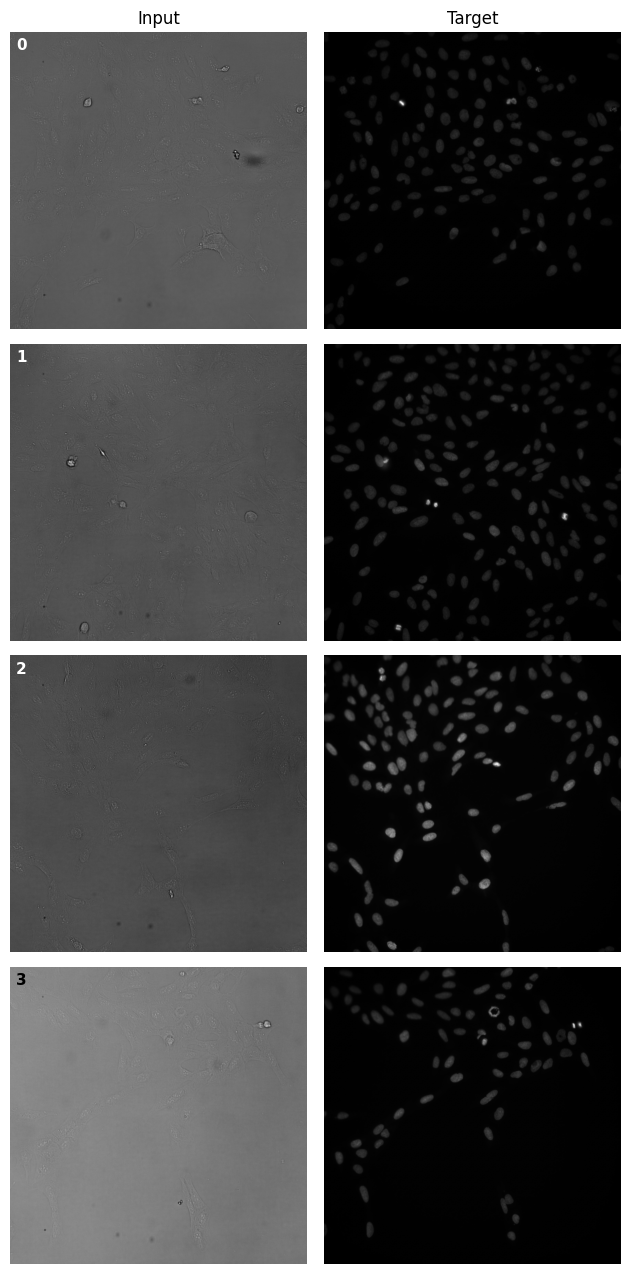

In [4]:
# Create a dataset with Brightfield as input and Hoechst as target
# See https://github.com/jump-cellpainting/2024_Chandrasekaran_NatureMethods_CPJUMP1
# for which channel codes correspond to which channel
dataset = BaseImageDataset(
    file_index=file_index,
    check_exists=True,
    pil_image_mode="I;16",
    input_channel_keys=["ch7"],
    target_channel_keys=["ch5"],
)
print(f"Dataset length: {len(dataset)}")
print(
    f"Input channels: {dataset.input_channel_keys}, target channels: {dataset._target_channel_keys}"
)
plot_dataset_grid(
    dataset=dataset,
    indices=[0,1,2,3],
    wspace=0.025,
    hspace=0.05
)

## Generate cropped dataset by taking the center 256 x 256 square using built in utilities.
Also visualize the first few crops

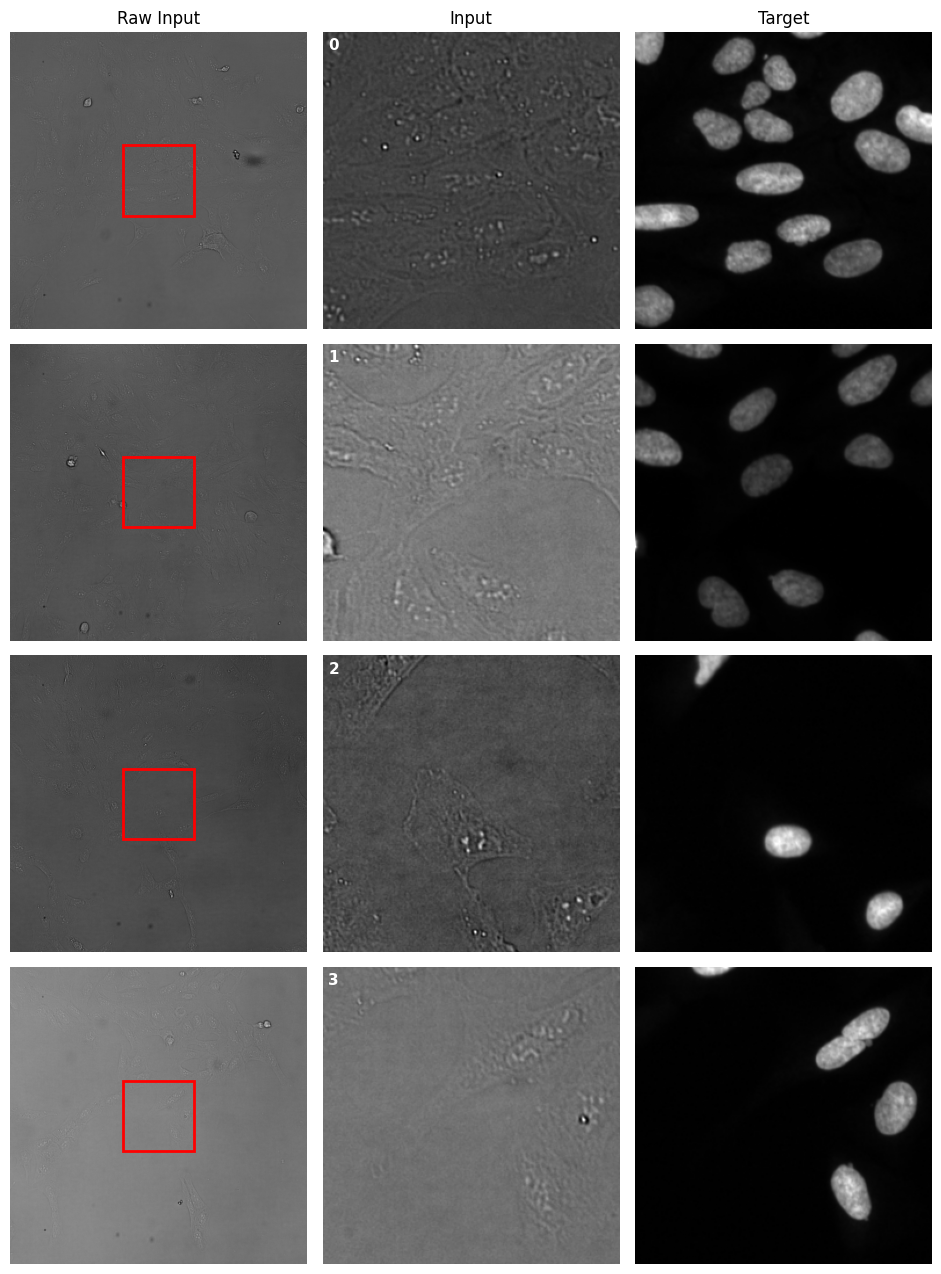

In [5]:
cropped_dataset = CropImageDataset.from_base_dataset(
    dataset,
    crop_size=256,    
    transforms=MaxScaleNormalize(
        normalization_factor='16bit'
    )
)
plot_dataset_grid(
    dataset=cropped_dataset,
    indices=[0,1,2,3],
    wspace=0.025,
    hspace=0.05
)

## Configure and train

In [6]:
## Hyperparameters

# Batch size arbitrarily chosen for demo purposes. 
# With a value of 16, the training fits comfortably into a nvidia RTX 3090 and utilizing <10GB of VRAM.
# Tune to your hardware capabilities.
batch_size = 16 

# Small number of epochs for demo purposes
# For better training results, increase this number
epochs = 100

# larger learning rate for demo purposes,
# such that the epoch to epoch changes in model predictions are more visible
learning_rate = 0.001 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batch with DataLoader
train_loader = DataLoader(cropped_dataset, batch_size=batch_size, shuffle=True)

# Model & Optimizer
fully_conv_unet = UNet(
    in_channels=1,
    out_channels=1,
    depth=4,
    encoder_down_block='conv',
    decoder_up_block='convt',
    act_type='sigmoid'
)
optimizer = torch.optim.Adam(fully_conv_unet.parameters(), lr=learning_rate)

# Plotting callback to visualize predictions during training
# At the end of every n epochs, the callback takes the most recent model
# weights and runs inference on the provided images (dataset indexed by sample indices).
# And plots the predictions alongside the inputs and targets to give a visual sense of training progress.
#
# This gets bounded to the logger instance below to automatically register
# plots to the training. 
plot_callback = PlotPredictionCallback(
    name="plot_callback_with_train_data",
    dataset=cropped_dataset,
    indices=[0,1,2,3,4], # first 5 samples
    plot_metrics=[torch.nn.L1Loss()],
    every_n_epochs=5,
    # kwargs passed to plotting backend
    show_plot=False, # don't show plot in notebook
    wspace=0.025, # small spacing between subplots
    hspace=0.05 # small spacing between subplots
)

# MLflow Logger
# The logger that communicates with an MLflow tracking server.
# The Mlflow logger by default logs all metrics and losses specified to the
# trainer, plus any files (artifacts in mlflow terminology) generated by the callbacks.
#
# The logger by default saves the model weights at the end of every epoch and
# the best model weights according to validation loss (not applicable here since no val set).
# The only additional callback bound to the logger is plotting callback defined above. 
# Thus the only files being logged are the plots and the model weights.
logger = MlflowLogger(
    name="logger",
    experiment_name="vsf_examples",
    # Change to your MLflow tracking server/local file based tracking URI
    tracking_uri="http://127.0.0.1:5000", 
    run_name="experiment_training_with_plots",
    description="Training a UNet model on a simple dataset for demo purposes",
    callbacks=[plot_callback],
    save_model_at_train_end=True,
    save_model_every_n_epochs=1,
    save_best_model=True
)

# Initialize Trainer and start training
trainer = SingleGeneratorTrainer(
    model=fully_conv_unet, # the UNet defined above
    optimizer=optimizer, # the Adam optimizer defined above
    losses=[ # Training with 2 losses: L1 and MS-SSIM
        torch.nn.L1Loss(), # simple per pixel error
        MultiScaleStructuralSimilarityIndexMeasure( # helps models converge much faster
            data_range=1.0, 
            kernel_size=11,
            sigma=1.5,
        )
    ],
    loss_weights=[1.0, -1.0], # minimize L1 distance (lower is better) and maximize MS-SSIM (higher is better)
    device=device, # use GPU if available
    train_loader=train_loader, # training data loader
    val_loader=None, # for demo purposes, we don't supply a validation set
    test_loader=None, # for demo purposes, we don't supply a test set
)

# Start training
trainer.train(logger=logger, epochs=epochs)

MLflow run started with ID: 22e70bf03064493cab1e526970980454


Training: 100%|██████████| 100/100 [06:45<00:00,  4.06s/epoch, Train Batch 4/4]


🏃 View run experiment_training_with_plots at: http://127.0.0.1:5000/#/experiments/2/runs/22e70bf03064493cab1e526970980454
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


## Visualize training outcome through MLflow client

### Display the last logged prediction plot artifact

Run ID: 22e70bf03064493cab1e526970980454
Run Name: experiment_training_with_plots
Last epoch plot: plots/epoch/plot_predictions/epoch_99.png


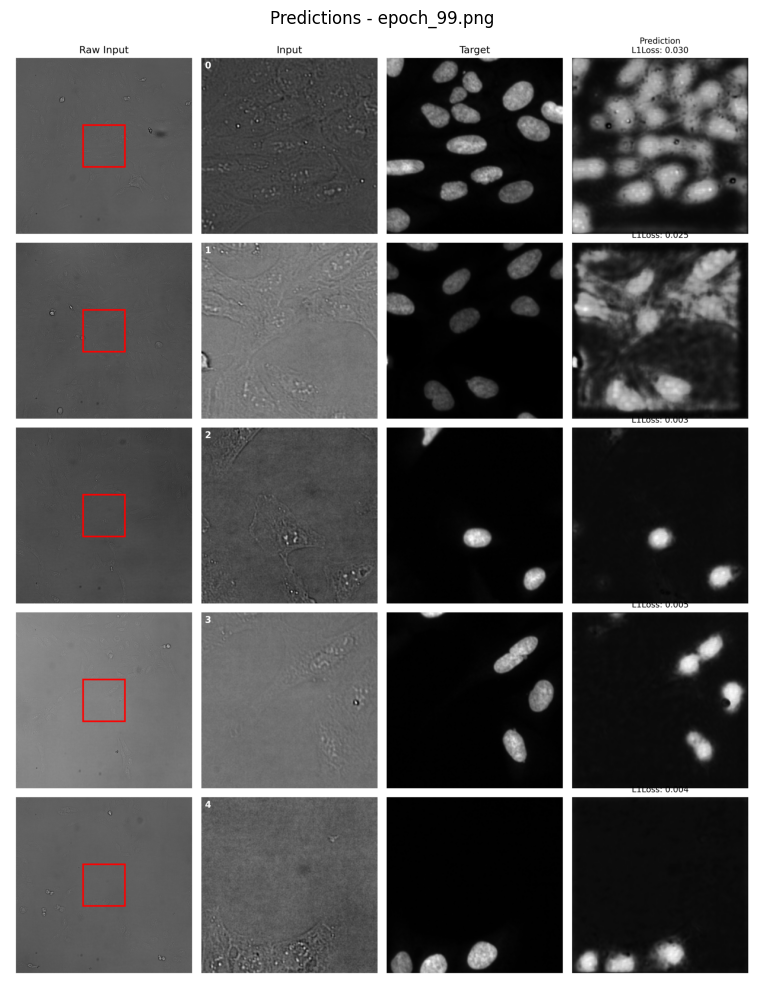

In [7]:
# Create MLflow client
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

# Get the experiment by name
# should match the experiment name specified in the MlflowLogger above
experiment = client.get_experiment_by_name("vsf_examples")

if experiment is None:
    print("Experiment 'vsf_examples' not found")
else:
    # Search for runs with the specific run name
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="tags.mlflow.runName = 'experiment_training_with_plots'"
    )
    
    if len(runs) == 0:
        print("No runs found with name 'experiment_training_with_plots'")
    else:
        # Get the most recent run (first in list)
        run = runs[0]
        print(f"Run ID: {run.info.run_id}")
        print(f"Run Name: {run.data.tags.get('mlflow.runName')}")

        # List artifacts (files) produced during training.
        plot_artifacts = client.list_artifacts(run.info.run_id, path='plots/epoch/plot_predictions/')

        # Filter for PNG files and sort by path (which includes epoch number)
        png_files = [artifact for artifact in plot_artifacts if artifact.path.endswith('.png')]

        # Get full paths and sort by epoch number
        png_files_sorted = sorted(png_files, key=lambda x: int(x.path.split('_')[-1].split('.')[0]))
        most_recent_png = png_files_sorted[-1]

        print(f"Last epoch plot: {most_recent_png.path}")

        # Download and display the image
        # (visualizing the most recent prediction plots, at the end of training)
        local_path = client.download_artifacts(run.info.run_id, most_recent_png.path)
        img = Image.open(local_path)
        plt.figure(figsize=(12, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predictions - {most_recent_png.path.split('/')[-1]}")
        plt.tight_layout()
        plt.show()

With the default hyperparameters, small subsetted dataset and small number of trianing epochs, we shouldn't expect the model to train well.
As anticipated, the last prediction plots display signs of under training. 

For better training results, consider:
- lowering learning rate to allow more fine grained convergence to local/global optima.
- significantly increase the training epochs to prevent underfitting.
- increase sample size so the model can't cheat and overfit to a small dataset.

### Also visualize metrics from tracking

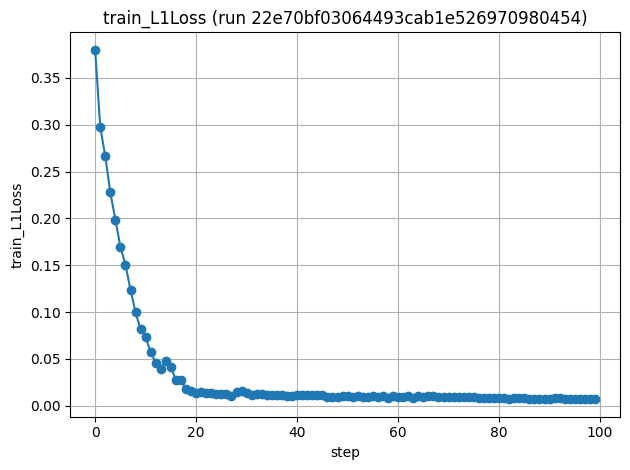

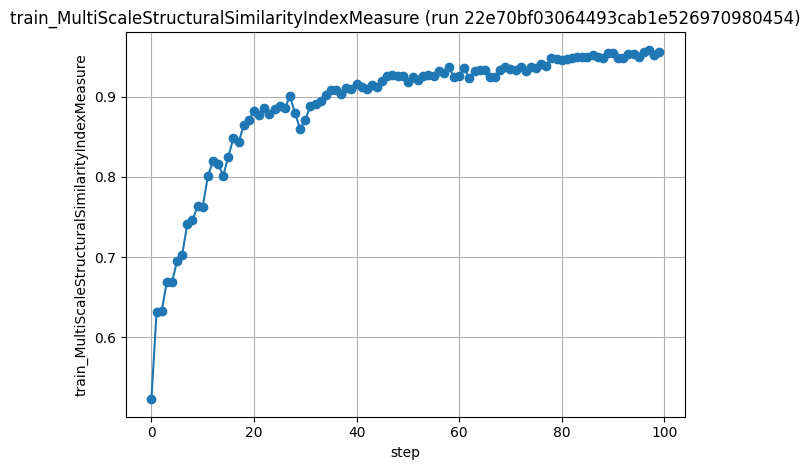

In [8]:
metric_keys = list(run.data.metrics.keys()) or []

for metric_name in metric_keys:
    # 2. Get full history for each metric (all steps)
    history = client.get_metric_history(run.info.run_id, metric_name)
    if not history:
        continue

    steps = [m.step for m in history]
    values = [m.value for m in history]

    # 3. Plot each metric vs step
    plt.figure()
    plt.plot(steps, values, marker="o")
    plt.title(f"{metric_name} (run {run.info.run_id})")
    plt.xlabel("step")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.tight_layout()

As anitipated, the error (L1) decreased over the course of training, 
and the SSIM index, a measurement of how well the predicted images resembles the truth, increases.